In [1]:
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
from descartes import PolygonPatch
from IPython.display import IFrame
ox.config(log_console=True, use_cache=True)

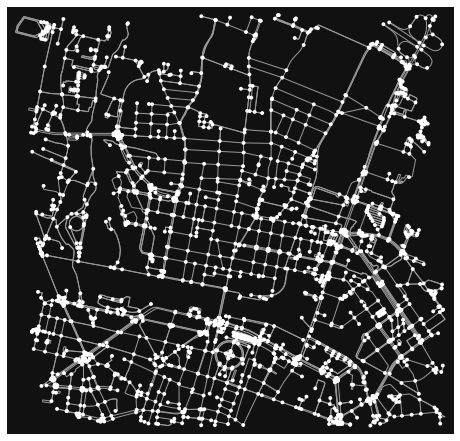

<Figure size 1440x1440 with 0 Axes>

In [26]:
# 1. Place you are interested
place = "Bolognina"
# 2. Transportation mode
# Transport mode = ‘walk’, ‘bike’, ‘drive’, ‘drive_service’, ‘all’, ‘all_private’, ‘none’
mode = "bike"
# 3. Create network graph from place and mode
G = ox.graph_from_address(place, dist=1500, simplify=True, network_type=mode)
# 4. Plot the network graph
fig, ax = ox.plot_graph(G);
#plt.suptitle('Bologna roads & cyclepath network', fontsize=20)
plt.figure(figsize=(20,20))
plt.tight_layout()
plt.show()

In [27]:
def create_graph(loc, dist, transport_mode, loc_type="address"):
    # Transport mode = ‘walk’, ‘bike’, ‘drive’, ‘drive_service’, ‘all’, ‘all_private’, ‘none’
    if loc_type == "address":
        G = ox.graph_from_address(loc, dist=dist, network_type=transport_mode)
    elif loc_type == "points":
        G = ox.graph_from_point(loc, dist=dist, network_type=transport_mode )
    return G

In [28]:
# 1 - Create a graph
G = create_graph(loc= "Bolognina", dist= 8000, transport_mode= "bike")
# 2 - Create nodes geodataframe from Graph network (G)
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
# 3 - Specify where you want to start and get nearest nodes. 
# This is now set the the Bolognina main cross
point_of_interest = ox.get_nearest_node(G, point=(44.509194, 11.344467))
# 4 - Project a graph from lat-long to the UTM zone appropriate for its geographic location.
G = ox.project_graph(G)

In [29]:
# Trip time in Mintues
trip_times = [5, 10, 15, 30]

# bike pedaling speed in km/hour
travel_speed = 16 # the same as Google Map

# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

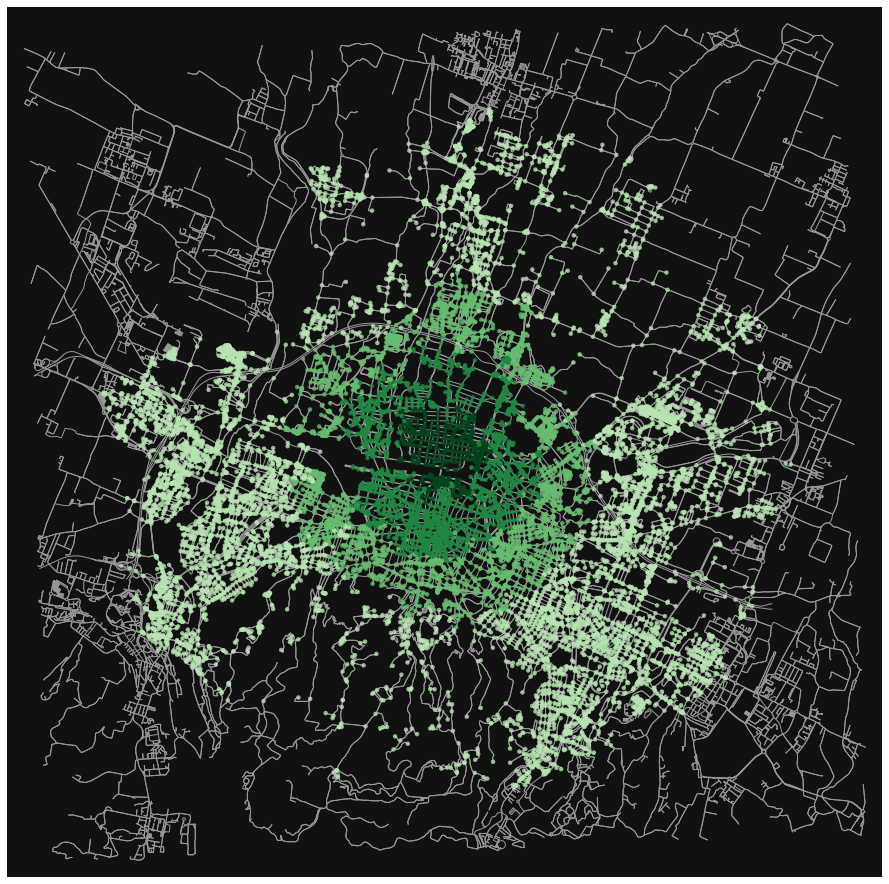

In [30]:
# 1 - get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='Greens', start=0.3, return_hex=True)
# 2 - color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, point_of_interest, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [20 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, figsize=(16,16), node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)


In [31]:
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, point_of_interest, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

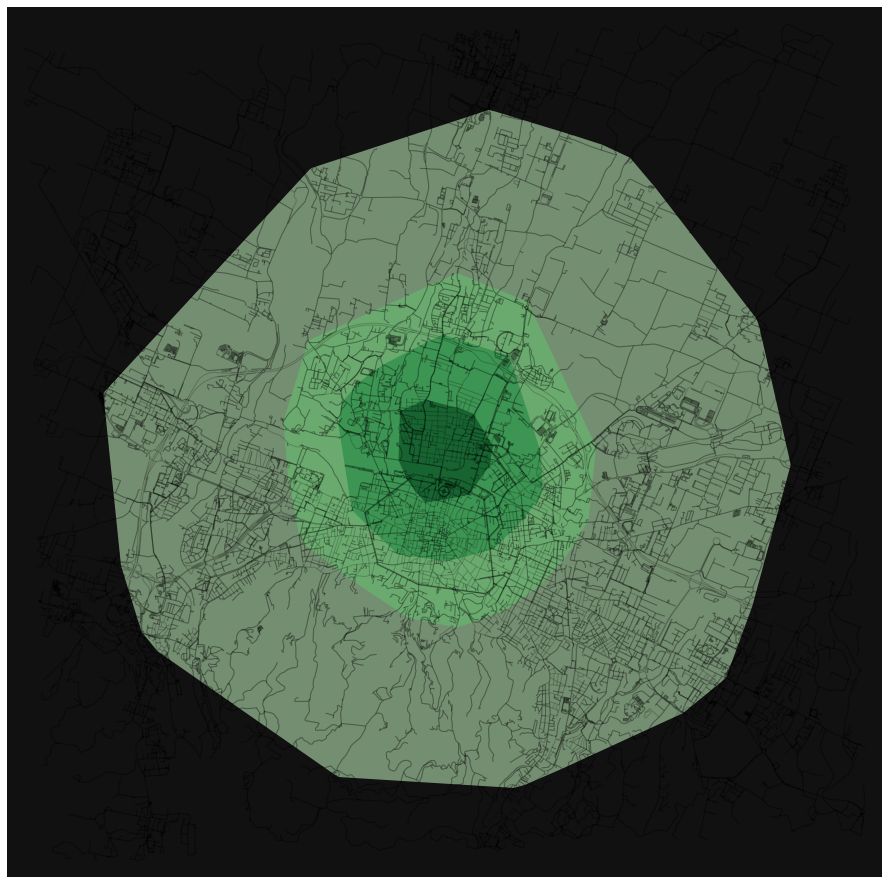

In [32]:
# plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(G, figsize=(16,16), show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()    